# Task 1: Building a CNN from Scratch for Pet Classification

# 1. Introduction and Setup

In this notebook, we'll build a CNN from scratch for the Oxford-IIIT Pet Dataset classification challenge. We'll start with binary classification (Dog vs. Cat) and then extend to fine-grained breed classification.

In [2]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, classification_report

## 1.2 Set Up Environment and Seed for Reproducibility

Setting a random seed ensures that our results are reproducible across different runs.

In [3]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    # Set deterministic backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed()

# Check for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# 2. Data Loading and Preprocessing

Let's load and explore the Oxford-IIIT Pet Dataset, which contains images of 37 pet breeds (25 dog breeds and 12 cat breeds).

In [5]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load train+validation and test sets
trainval_dataset = datasets.OxfordIIITPet(root="./data", split="trainval", transform=transform, download=True)
test_dataset = datasets.OxfordIIITPet(root="./data", split="test", transform=transform, download=True)

# Print dataset sizes
print(f"Total Train+Validation size: {len(trainval_dataset)}")  # Should be 3,680
print(f"Total Test size: {len(test_dataset)}")  # Should be 3,669

# Explore dataset classes
class_to_idx = trainval_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
print(f"Number of classes: {len(class_to_idx)}")

# Check which classes are dogs vs cats
dog_classes = [name for name in class_to_idx.keys() if name not in ["Abyssinian", "Bengal", "Birman", "Bombay", "British_Shorthair", 
                                                                  "Egyptian_Mau", "Maine_Coon", "Persian", "Ragdoll", 
                                                                  "Russian_Blue", "Siamese", "Sphynx"]]
cat_classes = [name for name in class_to_idx.keys() if name not in dog_classes]

print(f"Dog classes ({len(dog_classes)}): {dog_classes}")
print(f"Cat classes ({len(cat_classes)}): {cat_classes}")

Total Train+Validation size: 3680
Total Test size: 3669
Number of classes: 37
Dog classes (29): ['American Bulldog', 'American Pit Bull Terrier', 'Basset Hound', 'Beagle', 'Boxer', 'British Shorthair', 'Chihuahua', 'Egyptian Mau', 'English Cocker Spaniel', 'English Setter', 'German Shorthaired', 'Great Pyrenees', 'Havanese', 'Japanese Chin', 'Keeshond', 'Leonberger', 'Maine Coon', 'Miniature Pinscher', 'Newfoundland', 'Pomeranian', 'Pug', 'Russian Blue', 'Saint Bernard', 'Samoyed', 'Scottish Terrier', 'Shiba Inu', 'Staffordshire Bull Terrier', 'Wheaten Terrier', 'Yorkshire Terrier']
Cat classes (8): ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'Persian', 'Ragdoll', 'Siamese', 'Sphynx']


## 2.2 Create Binary Classification Dataset (Dogs vs. Cats)

For the first task, we need to convert the 37 breed labels into binary labels (Dog vs. Cat).

In [6]:
# Create a binary classification dataset (Dog vs. Cat)
class BinaryPetDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        
        # Oxford dataset has first 25 classes as dogs (0-24) and last 12 as cats (25-36)
        self.dog_indices = list(range(25))
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        # Convert multi-class label to binary: Dogs (1) vs. Cats (0)
        binary_label = 1 if label in self.dog_indices else 0
        return img, binary_label

# Create binary versions of datasets
binary_trainval_dataset = BinaryPetDataset(trainval_dataset)
binary_test_dataset = BinaryPetDataset(test_dataset)

# Split trainval into train and validation (80% train, 20% validation)
train_size = int(0.8 * len(binary_trainval_dataset))
val_size = len(binary_trainval_dataset) - train_size
binary_train_dataset, binary_val_dataset = random_split(binary_trainval_dataset, [train_size, val_size])

# Create data loaders
batch_size = 32
binary_train_loader = DataLoader(binary_train_dataset, batch_size=batch_size, shuffle=True)
binary_val_loader = DataLoader(binary_val_dataset, batch_size=batch_size)
binary_test_loader = DataLoader(binary_test_dataset, batch_size=batch_size)

print(f"Binary train set size: {len(binary_train_dataset)}")
print(f"Binary validation set size: {len(binary_val_dataset)}")
print(f"Binary test set size: {len(binary_test_dataset)}")

Binary train set size: 2944
Binary validation set size: 736
Binary test set size: 3669


## 2.3 Implement Data Augmentation

Data augmentation helps improve model generalization by artificially expanding the training set through transformations.

In [7]:
# Define transformations with augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transformations for validation/testing (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Reload datasets with augmentation
trainval_dataset_aug = datasets.OxfordIIITPet(root="./data", split="trainval", transform=train_transform, download=False)
test_dataset_aug = datasets.OxfordIIITPet(root="./data", split="test", transform=val_transform, download=False)

# Create augmented binary datasets
binary_trainval_dataset_aug = BinaryPetDataset(trainval_dataset_aug)
binary_test_dataset_aug = BinaryPetDataset(test_dataset_aug)

# Split trainval into train and validation
binary_train_dataset_aug, binary_val_dataset_aug = random_split(binary_trainval_dataset_aug, [train_size, val_size])

# Create augmented data loaders
binary_train_loader_aug = DataLoader(binary_train_dataset_aug, batch_size=batch_size, shuffle=True)
binary_val_loader_aug = DataLoader(binary_val_dataset_aug, batch_size=batch_size)
binary_test_loader_aug = DataLoader(binary_test_dataset_aug, batch_size=batch_size)

### Visualize Augmented Samples

Let's visualize some augmented samples to see the effect of our data augmentation.

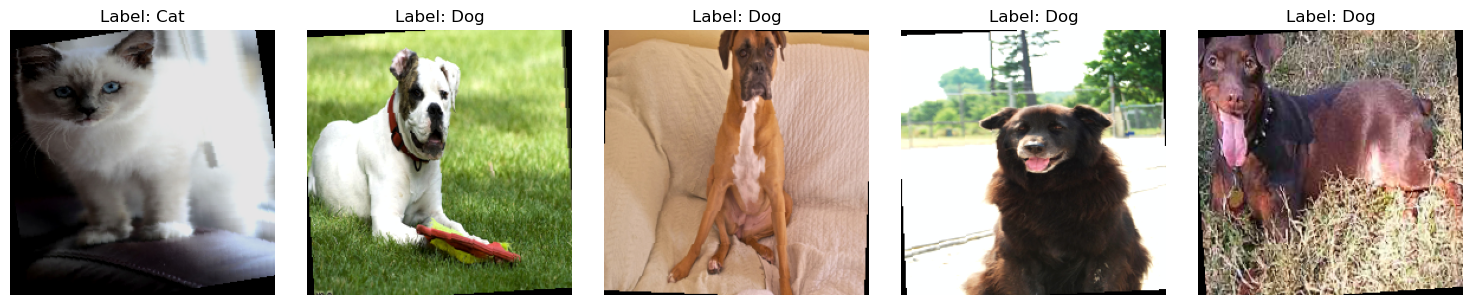

In [8]:
# Visualize some augmented samples
def show_augmented_samples(dataloader, num_samples=5):
    # Get a batch of images and labels
    images, labels = next(iter(dataloader))
    
    # Display images
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        img = images[i].permute(1, 2, 0).numpy()
        # Denormalize for visualization
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {'Dog' if labels[i] == 1 else 'Cat'}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

show_augmented_samples(binary_train_loader_aug)

# 3. Task 1 - Step 1: Binary Classification (Dog vs. Cat)

First, we'll build a CNN model for binary classification between dogs and cats.

## 3.1 Define CNN Model Architecture

We'll design a custom CNN architecture with convolutional layers, batch normalization, pooling, and dropout for regularization.

In [9]:
class BinaryPetCNN(nn.Module):
    def __init__(self):
        super(BinaryPetCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 1)
        
        # Dropout
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # Conv block 1
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        # Conv block 2
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        # Conv block 3
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        # Conv block 4
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        # Flatten
        x = x.view(-1, 256 * 14 * 14)
        
        # Fully connected with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        
        # Return sigmoid for binary classification
        return torch.sigmoid(x)

# Initialize the model and move to device
binary_model = BinaryPetCNN().to(device)
print(binary_model)

# Calculate number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {count_parameters(binary_model):,}")

BinaryPetCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Number of trainable parameters: 26,080,513


## 3.2 Define Loss Function, Optimizer, and Training Loop

We'll use Binary Cross Entropy Loss for binary classification, Adam optimizer, and implement a training loop with learning rate scheduling.

In [ ]:
# Binary Cross Entropy Loss for binary classification
criterion = nn.BCELoss()

# Adam optimizer with learning rate and weight decay (L2 regularization)
optimizer = optim.Adam(binary_model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler to reduce LR when validation loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# Training function
def train_binary_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20):
    start_time = time.time()
    best_val_acc = 0.0
    
    # Early stopping parameters
    patience = 7
    counter = 0
    best_val_loss = float('inf')
    early_stop = False
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        # Iterate over data
        for inputs, labels in binary_train_loader_aug:
            inputs = inputs.to(device)
            labels = labels.float().to(device).view(-1, 1)  # Shape for BCE loss
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # Backward + optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.5).float()
            running_corrects += torch.sum(preds == labels)
        
        epoch_loss = running_loss / len(binary_train_loader_aug.dataset)
        epoch_acc = running_corrects.double() / len(binary_train_loader_aug.dataset)
        
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        
        # No gradient computation for validation
        with torch.no_grad():
            for inputs, labels in binary_val_loader_aug:
                inputs = inputs.to(device)
                labels = labels.float().to(device).view(-1, 1)
                
                # Forward
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Statistics
                val_running_loss += loss.item() * inputs.size(0)
                preds = (outputs > 0.5).float()
                val_running_corrects += torch.sum(preds == labels)
        
        val_epoch_loss = val_running_loss / len(binary_val_loader_aug.dataset)
        val_epoch_acc = val_running_corrects.double() / len(binary_val_loader_aug.dataset)
        
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc.item())
        
        print(f'Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')
        
        # Update learning rate based on validation loss
        scheduler.step(val_epoch_loss)
        
        # Save the best model
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            torch.save(model.state_dict(), 'best_binary_model.pth')
    
    time_elapsed = time.time() - start_time
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_val_acc:.4f}')
    
    # Load the best model
    model.load_state_dict(torch.load('best_binary_model.pth'))
    return model, history

## 3.3 Train the Binary Classification Model

Now let's train our binary classification model.

In [ ]:
# Train the model
trained_binary_model, binary_history = train_binary_model(
    binary_model,
    binary_train_loader_aug, 
    binary_val_loader_aug, 
    criterion, 
    optimizer, 
    scheduler, 
    num_epochs=10
)

Epoch 1/20
----------


/Users/ndethi/anaconda3/envs/rai7004/lib/python3.11/site-packages/torch/autograd/__init__.py:266: UserWarning: Skipping device NVIDIA GeForce GTX 675MX that does not support Metal 2.0 (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403212643/work/aten/src/ATen/mps/MPSDevice.mm:101.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Train Loss: 32.8544 Acc: 0.6658
Val Loss: 30.1630 Acc: 0.6984
Epoch 2/20
----------
Train Loss: 33.1861 Acc: 0.6681
Val Loss: 30.1630 Acc: 0.6984
Epoch 3/20
----------
Train Loss: 33.1861 Acc: 0.6681
Val Loss: 30.1630 Acc: 0.6984
Epoch 4/20
----------
Train Loss: 33.1861 Acc: 0.6681
Val Loss: 30.1630 Acc: 0.6984
Epoch 5/20
----------
Train Loss: 33.1861 Acc: 0.6681
Val Loss: 30.1630 Acc: 0.6984
Epoch 6/20
----------
Train Loss: 33.1861 Acc: 0.6681
Val Loss: 30.1630 Acc: 0.6984
Epoch 7/20
----------
Train Loss: 33.1861 Acc: 0.6681
Val Loss: 30.1630 Acc: 0.6984
Epoch 8/20
----------
Train Loss: 33.1861 Acc: 0.6681
Val Loss: 30.1630 Acc: 0.6984
Epoch 9/20
----------
Train Loss: 33.1861 Acc: 0.6681
Val Loss: 30.1630 Acc: 0.6984
Epoch 10/20
----------


KeyboardInterrupt: 

## 3.4 Visualize Training Results

Let's visualize the training and validation loss/accuracy curves to analyze our model's performance.

In [12]:
# Plot training and validation loss/accuracy
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    
    # Plot accuracy
    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(binary_history)

NameError: name 'binary_history' is not defined

## 3.5 Evaluate Binary Classification Model on Test Set

Now that we've trained our model, let's evaluate its performance on the test set.

In [ ]:
def evaluate_binary_model(model, test_loader):
    model.eval()
    running_corrects = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            preds = (outputs > 0.5).float().view(-1)
            
            # Collect predictions and labels for confusion matrix
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Count correct predictions
            running_corrects += torch.sum(preds == labels)
    
    # Calculate accuracy
    acc = running_corrects.double() / len(test_loader.dataset)
    print(f'Test Accuracy: {acc:.4f}')
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Calculate precision, recall, and F1 scores
    report = classification_report(all_labels, all_preds, target_names=['Cat', 'Dog'])
    print("Classification Report:")
    print(report)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    classes = ['Cat', 'Dog']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    # Add text annotations to confusion matrix
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()
    
    return acc, cm, report

# Evaluate the binary model on test set
binary_test_acc, binary_cm, binary_report = evaluate_binary_model(trained_binary_model, binary_test_loader_aug)

# 4. Task 1 - Step 2: Fine-Grained Breed Classification

Now, we'll extend our model to classify the 37 specific pet breeds.

## 4.1 Create Multi-class Dataset Loaders

We'll create data loaders for the multi-class classification task.

In [ ]:
# Create multi-class data loaders (using augmentation)
multi_train_dataset = datasets.OxfordIIITPet(root="./data", split="trainval", transform=train_transform, download=False)
multi_test_dataset = datasets.OxfordIIITPet(root="./data", split="test", transform=val_transform, download=False)

# Split trainval into train and validation
train_size = int(0.8 * len(multi_train_dataset))
val_size = len(multi_train_dataset) - train_size
multi_train_dataset, multi_val_dataset = random_split(multi_train_dataset, [train_size, val_size])

# Create data loaders
multi_train_loader = DataLoader(multi_train_dataset, batch_size=batch_size, shuffle=True)
multi_val_loader = DataLoader(multi_val_dataset, batch_size=batch_size)
multi_test_loader = DataLoader(multi_test_dataset, batch_size=batch_size)

print(f"Multi-class train set size: {len(multi_train_dataset)}")
print(f"Multi-class validation set size: {len(multi_val_dataset)}")
print(f"Multi-class test set size: {len(multi_test_dataset)}")

## 4.2 Define Multi-class CNN Architecture

We'll modify our CNN architecture to handle 37 classes instead of binary classification.

In [ ]:
class MultiClassPetCNN(nn.Module):
    def __init__(self, num_classes=37):
        super(MultiClassPetCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(512 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        
        # Dropout
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # Conv block 1
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        # Conv block 2
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        # Conv block 3
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        # Conv block 4
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        # Conv block 5
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        
        # Flatten
        x = x.view(-1, 512 * 7 * 7)
        
        # Fully connected with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

# Initialize the model and move to device
multi_model = MultiClassPetCNN().to(device)
print(multi_model)

# Calculate number of parameters
print(f"Number of trainable parameters: {count_parameters(multi_model):,}")

## 4.3 Define Loss Function, Optimizer, and Training Loop for Multi-class Model

For multi-class classification, we'll use Cross Entropy Loss instead of BCE Loss.

In [ ]:
# Cross Entropy Loss for multi-class classification
multi_criterion = nn.CrossEntropyLoss()

# Adam optimizer with learning rate and weight decay
multi_optimizer = optim.Adam(multi_model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
multi_scheduler = optim.lr_scheduler.ReduceLROnPlateau(multi_optimizer, 'min', patience=3, factor=0.5)

# Training function for multi-class model
def train_multi_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25):
    start_time = time.time()
    best_val_acc = 0.0
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        # Iterate over data
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward + optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        
        # No gradient computation for validation
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Forward
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Statistics
                val_running_loss += loss.item() * inputs.size(0)